In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
PATH_TRAIN_DATASET = "../datasets/train.csv"
PATH_TEST_DATASET = "../datasets/test.csv"

train_df = pd.read_csv(PATH_TRAIN_DATASET, index_col=0)
test_df = pd.read_csv(PATH_TEST_DATASET, index_col=0)

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From kaggle:

**pclass**: A proxy for socio-economic status (SES)  
&emsp; 1st = Upper  
&emsp; 2nd = Middle  
&emsp; 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...  
&emsp; Sibling = brother, sister, stepbrother, stepsister  
&emsp; Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...  
&emsp; Parent = mother, father  
&emsp; Child = daughter, son, stepdaughter, stepson  
&emsp; Some children travelled only with a nanny, therefore parch=0 for them.

**embarked**: Port of Embarkation  
&emsp; C = Cherbourg  
&emsp; Q = Queenstown  
&emsp; S = Southampton

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


`Age`, `Cabin` and `Embarked` columns have missing values.

`Name`, `Sex`, `Ticket`, `Cabin` and `Embarked` columns contain string values.

In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


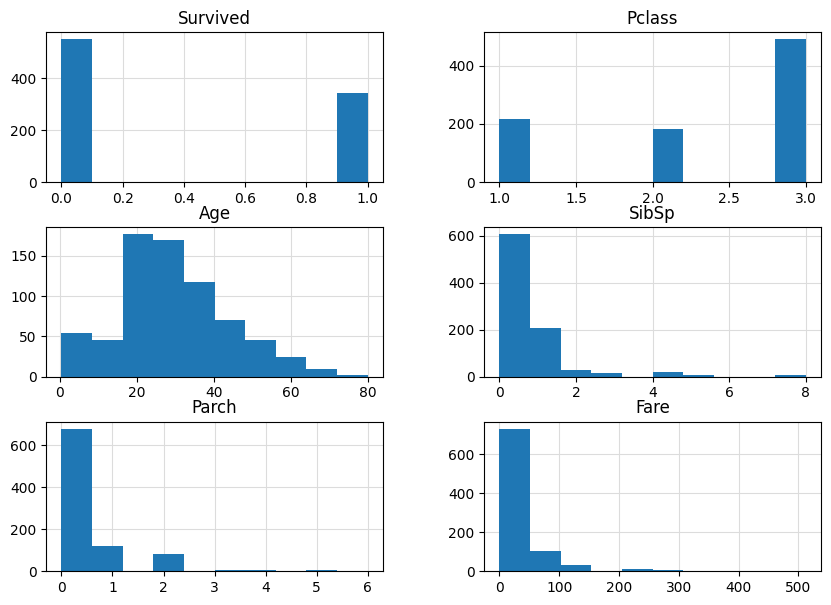

In [6]:
axes = train_df.hist(figsize=(10, 7))

for ax in axes.flatten():
    ax.grid(color="gainsboro")
    ax.set_axisbelow(True)

In [7]:
def cmap_hist_by(
    *,
    value: np.ndarray,
    patches: mpl.container.BarContainer,
    ax: mpl.axes.Axes,
    clb_title: str,
    cm: str = "seismic_r",
):
    cmap = plt.get_cmap(cm)

    for v, p in zip(value, patches):
        plt.setp(p, "facecolor", cmap(v))

    clb = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax)
    clb.set_label(clb_title)

In [8]:
def get_survived_cuts_mean(
    df: pd.DataFrame, column_cutted: str, bins: int or list, retbins: bool = True
) -> np.ndarray:
    survived_cuts, survived_bins = pd.cut(
        df[column_cutted], bins=10, right=False, retbins=retbins
    )

    survived_cuts_mean = df.groupby(survived_cuts).Survived.mean().to_numpy()

    if retbins:
        return survived_cuts_mean, survived_bins
    return survived_cuts_mean

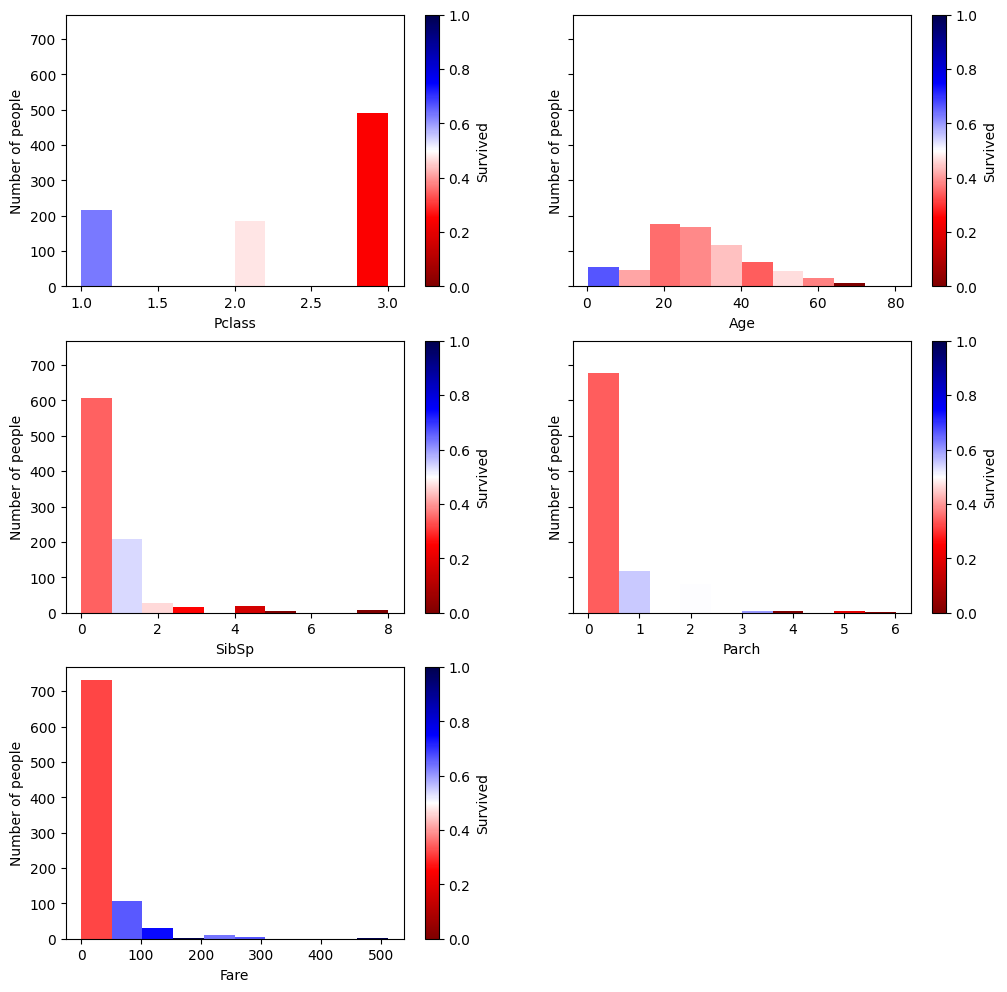

In [9]:
train_df_numeric = train_df.select_dtypes("number")
_columns = train_df_numeric.columns.drop("Survived")

fig, axs = plt.subplots(3, 2, figsize=(2 * 6, 3 * 4), sharey=True)
axs[2, 1].set_axis_off()

for ax, col in zip(axs.flatten(), _columns):
    survived_cuts_mean, survived_bins = get_survived_cuts_mean(train_df, col, bins=10)
    n, bins, patches = ax.hist(train_df_numeric[col], bins=survived_bins)

    cmap_hist_by(
        value=survived_cuts_mean,
        patches=patches,
        ax=ax,
        clb_title="Survived",
    )

    ax.set_ylabel("Number of people")
    ax.set_xlabel(col)